(np.float64(-4160698.738158422), np.float64(452237.57435588737))
UltimateBendingMomentResults(theta=0, n=np.float64(0.005582069105003029), m_y=np.float64(-181437697.1397316), m_z=np.float64(-45520.87717568874), chi_y=np.float64(-4.9846483269709586e-05), chi_z=np.float64(0.0), eps_a=0.008961620817427393)
Section Properties:
Total area: 125000.0
Reinforcement area: 942.4777960769379
Axial rigidity (E * A): 3938495559.215388
Mass per unit length: 0.3073984506992041
Perimeter: 1500.0
First moment of area (Sy): -197920.33717615716
Second moment of area (Sz): 0.0
E * Sy: -39584067435.231384
E * Sz: 3.814697265625e-06
Centroid y Coordinate: 9.68567111037939e-16
Centroid z Coordinate: -10.05055530470553
Second moment (Iyy): 2634870335.5335083
Second moment (Izz): 644393133.3028734
Product moment (Iyz): -501754.6218822375
Centroidal Second moment (Iyy_c): 2643613827.819169
Centroidal Second moment (Izz_c): 644393133.3028734
Centroidal Product moment (Iyz_c): -501754.62188217044
Principal Second

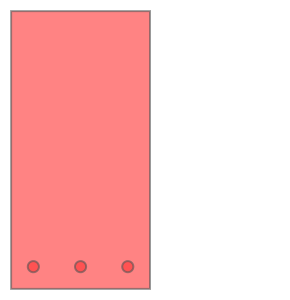

In [13]:
"""Quickstart example."""

from shapely import Polygon

from structuralcodes import set_design_code
from structuralcodes.geometry import SurfaceGeometry, add_reinforcement_line
from structuralcodes.materials.concrete import create_concrete
from structuralcodes.materials.reinforcement import create_reinforcement
from structuralcodes.sections import GenericSection
from structuralcodes.sections.section_integrators import FiberIntegrator
from structuralcodes.sections import GenericSectionCalculator

# Set the active design code
set_design_code('ec2_2004')

# Create a concrete and a reinforcement
fck = 45
fyk = 500
ftk = 550
Es = 200000
epsuk = 0.07

# These factory functions create concrete and reinforcement materials according
# to the globally set design code
concrete = create_concrete(fck=fck)
reinforcement = create_reinforcement(fyk=fyk, Es=Es, ftk=ftk, epsuk=epsuk)

# Create a rectangular geometry
width = 250
height = 500
polygon = Polygon(
    [
        (-width / 2, -height / 2),
        (width / 2, -height / 2),
        (width / 2, height / 2),
        (-width / 2, height / 2),
    ]
)  # We leverage shapely to create geometries
geometry = SurfaceGeometry(
    poly=polygon, material=concrete
)  # A SurfaceGeometry is a shapely Polygon with an assigned material

# Add reinforcement
diameter_reinf = 20
cover = 30
n_bars = 3

geometry = add_reinforcement_line(
    geometry,
    (-width / 2 + cover + diameter_reinf / 2,  (-height / 2 + cover + diameter_reinf / 2)),
    (width / 2 - cover - diameter_reinf / 2, (-height / 2 + cover + diameter_reinf / 2)),
    diameter_reinf,
    reinforcement,
    n=n_bars
)


# Create section
section = GenericSection(geometry)

# section calculator
section_calculator = GenericSectionCalculator(sec=section, integrator="fiber")

n = 8000
my = 1000000
mz = 500000

# Moment curvature response
moment_curvature = section_calculator.calculate_moment_curvature()
a = section_calculator.calculate_limit_axial_load()
b = section_calculator.calculate_bending_strength()
c = section_calculator._calculate_gross_section_properties()
d = section_calculator.calculate_strain_profile(n = n, my = my, mz = mz)
print(a)
print(b)
print(c)
print(d)

# Strain profile
strain = ([0.001, 0.0003, 0.0002])

# Integration functions
stress_resultants = section_calculator.integrate_strain_profile(strain)  # Beregner spenningsresultanter
stiffness_matrix = section_calculator.integrate_strain_profile(strain, integrate="modulus")  # Beregner stivhetsmatrisen


# 🔹 Print results with improved formatting
print("\n🔹 **Stress Resultants** (N, My, Mz):")
print(f"  - Normal Force (N):   {int(stress_resultants[0])/1e3:,.1f} kN")
print(f"  - Moment about Y (My): {int(stress_resultants[1])/1e6:,.1f} kNm")
print(f"  - Moment about Z (Mz): {int(stress_resultants[2])/1e6:,.1f} kNm")

print('\n Stiffness matrix: \n ', stiffness_matrix)

geometry

In [19]:
import typing as t
from structuralcodes.core.base import Material
 
 
class ShellReinforcement:
    """Represents reinforcement in a shell section.
 
    Attributes:
        num_bars (int): Number of bars per bundle.
        center_distance (float): Distance between the centers of adjacent bundles.
        bar_diameter (float): Diameter of individual bars (mm).
        bar_spacing (float): Distance between individual bars within a bundle.
        is_top (bool): True for top reinforcement, False for bottom.
        is_x_direction (bool): True if bars are in the x-direction, False for y-direction.
        position_y (float): Computed inside `ShellGeometry` to place bars correctly.
    """
 
    def __init__(
        self,
        bar_diameter: float,
        num_bars: int,
        center_distance: float,
        is_top: bool = True,
        is_x_direction: bool = True,  # X or Y direction
    ) -> None:
        """Initialize a ShellReinforcement object.
 
        Arguments:
            bar_diameter (float): Bar diameter (mm).
            num_bars (int): Number of bars per bundle.
            center_distance (float): Distance between bundles (center-to-center spacing).
            is_top (bool): If True, reinforcement is placed at the top; otherwise, at the bottom.
            is_x_direction (bool): If True, bars are in the x-direction; otherwise, y-direction.
        """
        if bar_diameter <= 0:
            raise ValueError("Bar diameter must be positive.")
        if num_bars <= 0:
            raise ValueError("num_bars must be greater than 0.")
        if center_distance <= 0:
            raise ValueError("center_distance must be greater than 0.")
 
        self.bar_diameter = bar_diameter
        self.num_bars = num_bars
        self.center_distance = center_distance
        self.is_top = is_top
        self.is_x_direction = is_x_direction
 
        # Compute spacing between bars within a bundle
        self.bar_spacing = bar_diameter  # Bars are spaced tightly within a bundle
 
        # `position_y` is set inside `ShellGeometry`, not here
 
    def get_rebar_positions(self, width: float) -> t.List[t.Tuple[float, float]]:
        """Compute all rebar positions for visualization, centering them correctly."""
        num_bundles = int((width - self.center_distance) // self.center_distance) + 1
        rebar_positions = []
 
        # Centering adjustment: Calculate the starting position
        total_bundle_width = (num_bundles - 1) * self.center_distance
        start_x = -total_bundle_width / 2  # Center bundles around 0
 
        for bundle_index in range(num_bundles):
            x_bundle = start_x + bundle_index * self.center_distance  # Start at centered position
 
            for bar_index in range(self.num_bars):
                x_bar = x_bundle + (bar_index - (self.num_bars - 1) / 2) * self.bar_spacing
 
                if -width / 2 <= x_bar <= width / 2:
                    rebar_positions.append((x_bar, 0))  # `position_y` is set inside `ShellGeometry`
 
        return rebar_positions
 
 

In [20]:
import typing as t
from structuralcodes.core.base import ConstitutiveLaw, Material
from structuralcodes.geometry import Geometry

class ShellGeometry(Geometry):
    def __init__(
        self,
        thickness: float,
        cover_depth: float,
        material: t.Union["Material", "ConstitutiveLaw"],
        Asx1: t.Optional["ShellReinforcement"] = None,
        Asx2: t.Optional["ShellReinforcement"] = None,
        Asy1: t.Optional["ShellReinforcement"] = None,
        Asy2: t.Optional["ShellReinforcement"] = None,
    ) -> None:
        super().__init__()
        if thickness <= 0 or cover_depth <= 0 or cover_depth >= thickness:
            raise ValueError("Invalid thickness or cover depth.")
        if not isinstance(material, (Material, ConstitutiveLaw)):
            raise TypeError("Invalid material type.")

        self.thickness = thickness
        self.cover_depth = cover_depth
        self.material = material
        self.Asx1, self.Asx2, self.Asy1, self.Asy2 = Asx1, Asx2, Asy1, Asy2
        self._compute_reinforcement_positions()

    def _compute_reinforcement_positions(self):
        for layer in [self.Asx1, self.Asx2, self.Asy1, self.Asy2]:
            if layer:
                base_y = (-self.thickness / 2 + self.cover_depth) if not layer.is_top else (self.thickness / 2 - self.cover_depth)
                if not layer.is_x_direction:  # Y-reinforcement
                    x_diameter = (self.Asx1.bar_diameter if self.Asx1 else layer.bar_diameter) if layer.is_top else (
                        self.Asx2.bar_diameter if self.Asx2 else layer.bar_diameter)
                    layer.position_y = base_y - (x_diameter + layer.bar_diameter) / 2 if layer.is_top else base_y + (
                            x_diameter + layer.bar_diameter) / 2
                else:
                    layer.position_y = base_y

    def _repr_svg_(self, view: str = "xz") -> str:
        """Returns an SVG representation of the shell geometry, including reinforcement.

        Arguments:
            view (str): Determines which reinforcement layers to display.
                        - "xz" -> Show XZ plane (red out of plane, blue parallel).
                        - "yz" -> Show YZ plane (blue out of plane, red parallel).
                        - "both" -> Show all views.
        """
        width, height = 1000, self.thickness
        svg_elements = [f'<svg width="{width+200}" height="{height+200}" '
                        f'viewBox="{-width/2-100} {-height/2-100} {width+200} {height+250}" '
                        f'xmlns="http://www.w3.org/2000/svg">']

        # **Concrete Section**
        svg_elements.append(f'<rect x="{-width/2}" y="{-height/2}" width="{width}" height="{height}" '
                            f'fill="lightgray" stroke="black" stroke-width="2"/>')

        # **Labels for TOP reinforcement**
        svg_elements.append(f'<text x="{-width/2+20}" y="{-height/2-40}" font-size="30" fill="red">Top X-Reinforcement (Asx2)</text>')
        svg_elements.append(f'<text x="{-width/2+20}" y="{-height/2-70}" font-size="30" fill="blue">Top Y-Reinforcement (Asy2)</text>')

        # **Labels for BOTTOM reinforcement**
        svg_elements.append(f'<text x="{-width/2+20}" y="{height/2+50}" font-size="30" fill="red">Bottom X-Reinforcement (Asx1)</text>')
        svg_elements.append(f'<text x="{-width/2+20}" y="{height/2+80}" font-size="30" fill="blue">Bottom Y-Reinforcement (Asy1)</text>')

        # **Reinforcement in XZ Plane**
        if view in ["xz", "both"]:
            for layer in [self.Asx1, self.Asx2]:
                if layer:
                    for x_bar, _ in layer.get_rebar_positions(width):
                        svg_elements.append(f'<circle cx="{x_bar}" cy="{layer.position_y}" r="{layer.bar_diameter/2}" '
                                            f'fill="red" stroke="black" stroke-width="1"/>')

            for layer in [self.Asy1, self.Asy2]:
                if layer:
                    svg_elements.append(f'<line x1="{-width/2}" y1="{layer.position_y}" '
                                        f'x2="{width/2}" y2="{layer.position_y}" '
                                        f'stroke="blue" stroke-width="{layer.bar_diameter}"/>')

        # **Reinforcement in YZ Plane**
        if view in ["yz", "both"]:
            for layer in [self.Asy1, self.Asy2]:
                if layer:
                    for y_bar, _ in layer.get_rebar_positions(width):
                        svg_elements.append(f'<circle cx="{y_bar}" cy="{layer.position_y}" r="{layer.bar_diameter/2}" '
                                            f'fill="blue" stroke="black" stroke-width="1"/>')

            for layer in [self.Asx1, self.Asx2]:
                if layer:
                    svg_elements.append(f'<line x1="{-width/2}" y1="{layer.position_y}" '
                                        f'x2="{width/2}" y2="{layer.position_y}" '
                                        f'stroke="red" stroke-width="{layer.bar_diameter}"/>')

        svg_elements.append("</svg>")
        return "".join(svg_elements)



In [21]:
import typing as t
from structuralcodes.core.base import ConstitutiveLaw, Material
from structuralcodes.geometry import Geometry

class ShellGeometry(Geometry):
    def __init__(
        self,
        thickness: float,
        cover_depth: float,
        material: t.Union["Material", "ConstitutiveLaw"],
        Asx1: t.Optional["ShellReinforcement"] = None,
        Asx2: t.Optional["ShellReinforcement"] = None,
        Asy1: t.Optional["ShellReinforcement"] = None,
        Asy2: t.Optional["ShellReinforcement"] = None,
    ) -> None:
        super().__init__()
        if thickness <= 0 or cover_depth <= 0 or cover_depth >= thickness:
            raise ValueError("Invalid thickness or cover depth.")
        if not isinstance(material, (Material, ConstitutiveLaw)):
            raise TypeError("Invalid material type.")

        self.thickness = thickness
        self.cover_depth = cover_depth
        self.material = material
        self.Asx1, self.Asx2, self.Asy1, self.Asy2 = Asx1, Asx2, Asy1, Asy2
        self._compute_reinforcement_positions()

    def _compute_reinforcement_positions(self):
        for layer in [self.Asx1, self.Asx2, self.Asy1, self.Asy2]:
            if layer:
                base_y = (-self.thickness / 2 + self.cover_depth) if not layer.is_top else (self.thickness / 2 - self.cover_depth)
                if not layer.is_x_direction:  # Y-reinforcement
                    x_diameter = (self.Asx1.bar_diameter if self.Asx1 else layer.bar_diameter) if layer.is_top else (
                        self.Asx2.bar_diameter if self.Asx2 else layer.bar_diameter)
                    layer.position_y = base_y - (x_diameter + layer.bar_diameter) / 2 if layer.is_top else base_y + (
                            x_diameter + layer.bar_diameter) / 2
                else:
                    layer.position_y = base_y

    def _repr_svg_(self, view: str = "xz") -> str:
        """Returns an SVG representation of the shell geometry, including reinforcement.

        Arguments:
            view (str): Determines which reinforcement layers to display.
                        - "xz" -> Show XZ plane (red out of plane, blue parallel).
                        - "yz" -> Show YZ plane (blue out of plane, red parallel).
                        - "both" -> Show all views.
        """
        width, height = 1000, self.thickness
        svg_elements = [f'<svg width="{width+200}" height="{height+200}" '
                        f'viewBox="{-width/2-100} {-height/2-100} {width+200} {height+250}" '
                        f'xmlns="http://www.w3.org/2000/svg">']

        # **Concrete Section**
        svg_elements.append(f'<rect x="{-width/2}" y="{-height/2}" width="{width}" height="{height}" '
                            f'fill="lightgray" stroke="black" stroke-width="2"/>')

        # **Labels for TOP reinforcement**
        svg_elements.append(f'<text x="{-width/2+20}" y="{-height/2-40}" font-size="30" fill="red">Top X-Reinforcement (Asx2)</text>')
        svg_elements.append(f'<text x="{-width/2+20}" y="{-height/2-70}" font-size="30" fill="blue">Top Y-Reinforcement (Asy2)</text>')

        # **Labels for BOTTOM reinforcement**
        svg_elements.append(f'<text x="{-width/2+20}" y="{height/2+50}" font-size="30" fill="red">Bottom X-Reinforcement (Asx1)</text>')
        svg_elements.append(f'<text x="{-width/2+20}" y="{height/2+80}" font-size="30" fill="blue">Bottom Y-Reinforcement (Asy1)</text>')

        # **Reinforcement in XZ Plane**
        if view in ["xz", "both"]:
            for layer in [self.Asx1, self.Asx2]:
                if layer:
                    for x_bar, _ in layer.get_rebar_positions(width):
                        svg_elements.append(f'<circle cx="{x_bar}" cy="{layer.position_y}" r="{layer.bar_diameter/2}" '
                                            f'fill="red" stroke="black" stroke-width="1"/>')

            for layer in [self.Asy1, self.Asy2]:
                if layer:
                    svg_elements.append(f'<line x1="{-width/2}" y1="{layer.position_y}" '
                                        f'x2="{width/2}" y2="{layer.position_y}" '
                                        f'stroke="blue" stroke-width="{layer.bar_diameter}"/>')

        # **Reinforcement in YZ Plane**
        if view in ["yz", "both"]:
            for layer in [self.Asy1, self.Asy2]:
                if layer:
                    for y_bar, _ in layer.get_rebar_positions(width):
                        svg_elements.append(f'<circle cx="{y_bar}" cy="{layer.position_y}" r="{layer.bar_diameter/2}" '
                                            f'fill="blue" stroke="black" stroke-width="1"/>')

            for layer in [self.Asx1, self.Asx2]:
                if layer:
                    svg_elements.append(f'<line x1="{-width/2}" y1="{layer.position_y}" '
                                        f'x2="{width/2}" y2="{layer.position_y}" '
                                        f'stroke="red" stroke-width="{layer.bar_diameter}"/>')

        svg_elements.append("</svg>")
        return "".join(svg_elements)



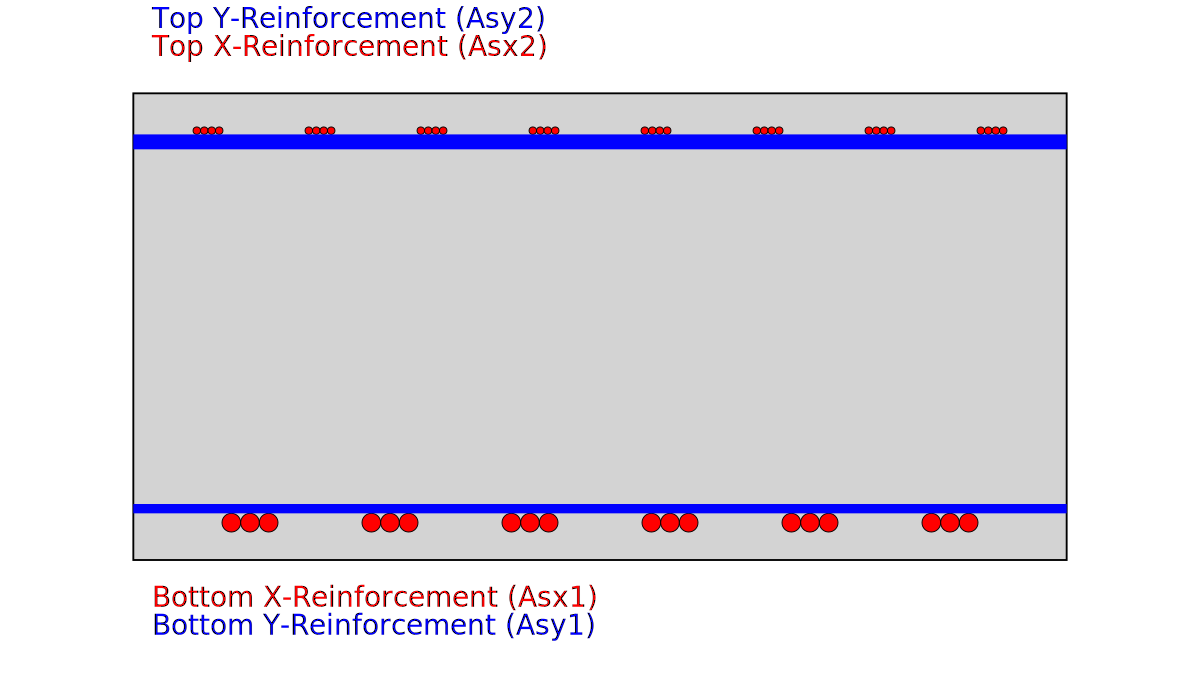

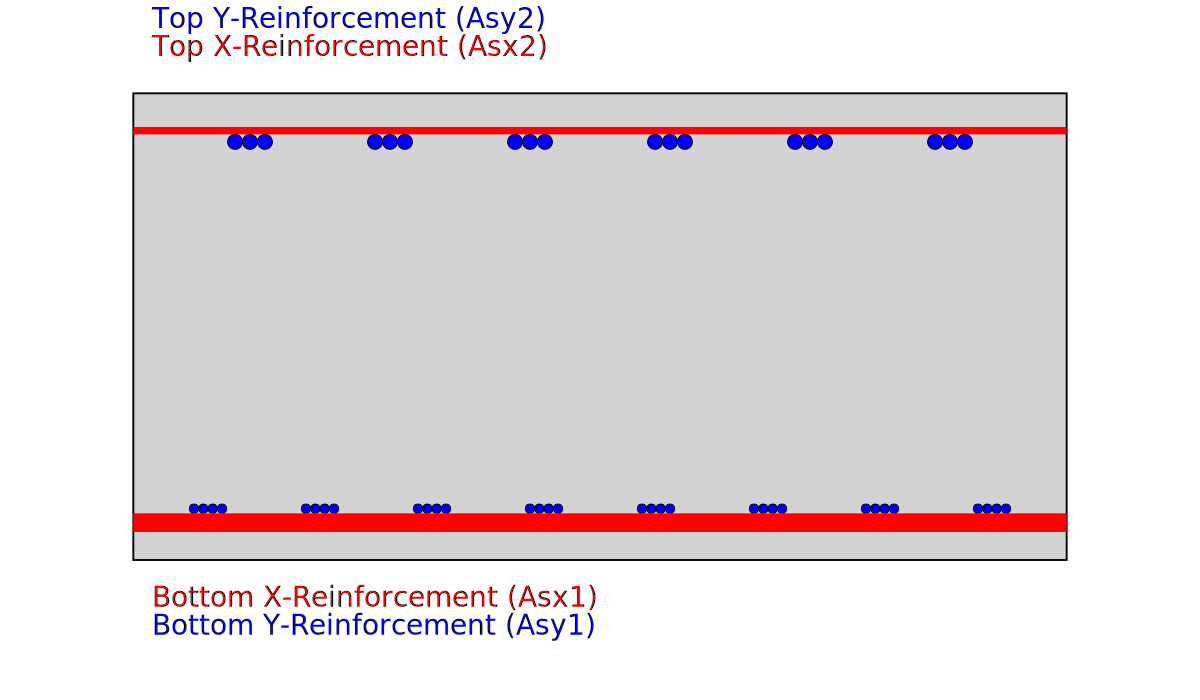

In [22]:
from structuralcodes.materials.reinforcement import create_reinforcement
from structuralcodes.materials.concrete import create_concrete
from structuralcodes import set_design_code

set_design_code("ec2_2004")

reinforcement_material = create_reinforcement(fyk=500, Es=200000, ftk=550, epsuk=0.07)

Asx1 = ShellReinforcement(bar_diameter=20, num_bars=3, center_distance=150, is_top=True)
Asx2 = ShellReinforcement(bar_diameter=8, num_bars=4, center_distance=120, is_top=False)
Asy1 = ShellReinforcement(bar_diameter=10, num_bars=4, center_distance=120, is_top=True, is_x_direction=False)
Asy2 = ShellReinforcement(bar_diameter=16, num_bars=3, center_distance=150, is_top=False, is_x_direction=False) 

shell_geometry = ShellGeometry(
    thickness=500,
    cover_depth=40,
    material=reinforcement_material,
    Asx1=Asx1, 
    Asx2=Asx2, 
    Asy1=Asy1, 
    Asy2=Asy2 
)

from IPython.display import display, SVG

# XZ Plane (Side view: Red out of plane, Blue parallel)
display(SVG(data=shell_geometry._repr_svg_("xz")))

# YZ Plane (Side view: Blue out of plane, Red parallel)
display(SVG(data=shell_geometry._repr_svg_("yz")))